# Install required libraries
To install the required libraries from the requirements file, use the following command:
"pip install -r requirements.txt"

# Directed by:
- Kevin: 0, 1, 2, 3, 4, 8.4, 8.5
- Gabriel: 3, 4, 5, 6, 7, 8.1, 8.2, 8.3

# 0. Initialization

In [167]:
import pandas as pd  # Library for data manipulation and analysis, often used for handling tabular data

# Visualization Libraries
import matplotlib.pyplot as plt  # Module for data visualization through plots and charts
import seaborn as sns  # Data visualization library built on Matplotlib, offering advanced plotting functions and attractive visual styles
import matplotlib.ticker as ticker  # Module for customizing axis tick labels and formatting in Matplotlib plots

# Regression Models for Predicting Continuous Values
from sklearn.tree import DecisionTreeRegressor  # Decision Tree model for regression tasks
from sklearn.metrics import mean_absolute_error, r2_score  # Metrics for evaluating model performance
from sklearn.ensemble import RandomForestRegressor  # Random Forest model for regression, an ensemble of decision trees
from sklearn.model_selection import GridSearchCV  # Tool for hyperparameter tuning using grid search and cross-validation

# Data Processing and Splitting
from sklearn.model_selection import train_test_split  # Function to split data into training and test sets

# Suppress warning messages
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings to keep the output clean

# 1. Collect the data

In [168]:
# Load the dataset from the specified path
data = pd.read_csv("../data/G3_immobiliers.csv")

# 2. Data cleaning and preparation

In [169]:
# Display the first 10 rows of the dataset to understand its structure
data.head(10)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
0,2022-1343146,2022-02-04,1,Vente,420000.0,NaN,NaN,LA CADISCIE,B009,81220.0,...,NaN,NaN,T,terres,NaN,NaN,1215.0,1.950729,43.64992,0000A
1,2022-1343521,2022-01-28,1,Vente,1500.0,NaN,NaN,SERRO,B168,81260.0,...,NaN,NaN,P,prés,NaN,NaN,1000.0,2.5195,43.618791,0000C
2,2022-1343592,2022-01-28,2,Vente,105000.0,NaN,NaN,PUECH ROUGE,B026,81170.0,...,NaN,NaN,P,prés,NaN,NaN,3900.0,1.896586,44.044786,0000A
3,2022-1343732,2022-02-10,1,Vente,5000.0,NaN,NaN,FOURMENTAL,B029,81300.0,...,NaN,NaN,T,terres,NaN,NaN,2770.0,2.031586,43.697737,0000B
4,2022-1343732,2022-02-10,1,Vente,5000.0,NaN,NaN,FOURMENTAL,B029,81300.0,...,NaN,NaN,T,terres,NaN,NaN,591.0,2.031218,43.697683,0000B
5,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,1762.0,1.667288,43.859966,0000C
6,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,P,prés,NaN,NaN,5505.0,1.66712,43.85981,0000C
7,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,18.0,1.667785,43.859678,0000C
8,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,70.0,1.667777,43.859631,0000C
9,2022-1343779,2022-02-11,1,Vente,173000.0,NaN,NaN,BAURUNE,B003,81120.0,...,NaN,NaN,T,terres,NaN,NaN,2022.0,2.087579,43.805298,0000D


In [170]:
# Display dataset information including column names, data types, and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146215 entries, 0 to 146214
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   id_mutation                   146215 non-null  object
 1   date_mutation                 146215 non-null  object
 2   numero_disposition            146215 non-null  object
 3   nature_mutation               146215 non-null  object
 4   valeur_fonciere               145482 non-null  object
 5   adresse_numero                67801 non-null   object
 6   adresse_suffixe               2927 non-null    object
 7   adresse_nom_voie              146142 non-null  object
 8   adresse_code_voie             146143 non-null  object
 9   code_postal                   146143 non-null  object
 10  code_commune                  146215 non-null  object
 11  nom_commune                   146215 non-null  object
 12  code_departement              146215 non-null  object
 13 

In [171]:
# Get statistical summaries of numerical columns
data.describe()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
count,146215,146215,146215,146215,145482.0,67801.0,2927,146142,146143,146143.0,...,42035.0,63503.0,134685,134685,20624,20624,134685.0,145142.000000,145142.00000,146215
unique,25492,891,15,6,7244.0,2702.0,11,12527,2290,99.0,...,945.0,32.0,22,22,27,27,14490.0,59856.000000,59338.00000,303
top,2022-1349012,2022-07-12,1,Vente,150000.0,1.0,B,LE VILLAGE,B020,81100.0,...,80.0,0.0,S,sols,FRICH,Friche,500.0,2.773587,43.64924,0000B
freq,480,933,102435,142495,1210.0,1954.0,2131,707,1016,8966.0,...,797.0,18640.0,55206,55206,5250,5250,2690.0,171.000000,171.00000,19936


In [172]:
# Check the total number of missing values in each column
data.isnull().sum()

id_mutation                          0
date_mutation                        0
numero_disposition                   0
nature_mutation                      0
valeur_fonciere                    733
adresse_numero                   78414
adresse_suffixe                 143288
adresse_nom_voie                    73
adresse_code_voie                   72
code_postal                         72
code_commune                         0
nom_commune                          0
code_departement                     0
ancien_code_commune             146205
ancien_nom_commune              146205
id_parcelle                          0
ancien_id_parcelle              146205
numero_volume                   145960
lot1_numero                     135814
lot1_surface_carrez             142818
lot2_numero                     143440
lot2_surface_carrez             145473
lot3_numero                     145396
lot3_surface_carrez             145931
lot4_numero                     146035
lot4_surface_carrez      

In [173]:
# Drop unnecessary columns that are not useful for predictive modeling
df_data = data[["valeur_fonciere", "date_mutation",
    "code_postal", "code_commune", "nom_commune", "code_departement",
    "type_local", "surface_reelle_bati", "nombre_pieces_principales",
    "surface_terrain", "nature_culture"
]]

In [174]:
# Convert "valeur_fonciere" column to numeric, forcing errors to NaN
df_data["valeur_fonciere"] = pd.to_numeric(df_data["valeur_fonciere"], errors="coerce")
# Remove rows where "valeur_fonciere" is missing
df_data = df_data.dropna(subset=["valeur_fonciere"])

In [175]:
# Convert "surface_reelle_bati" column to numeric, forcing errors to NaN
df_data["surface_reelle_bati"] = pd.to_numeric(df_data["surface_reelle_bati"], errors="coerce")
# Remove rows where "surface_reelle_bati" is missing
df_data = df_data.dropna(subset=["surface_reelle_bati"])

In [176]:
# Remove rows with more than 50% missing values
df_data = df_data.dropna(thresh=len(df_data.columns) * 0.5)

In [177]:
# Fill missing values in numerical columns with the median
# Convert numerical columns to float type (forcing errors to NaN)
cols_num = ["surface_reelle_bati", "surface_terrain", "nombre_pieces_principales", "valeur_fonciere"]
for col in cols_num:
    df_data[col] = pd.to_numeric(df_data[col], errors="coerce")  # Convert to float
    df_data[col] = df_data[col].fillna(df_data[col].median())  # Replace NaN with median

In [178]:
# Fill missing values in categorical columns with "Unknown"
cols_cat = ["type_local", "nature_culture"]
for col in cols_cat:
    df_data[col] = df_data[col].fillna("Unknown")

In [179]:
# Convert categorical variables into dummy/indicator variables (One-Hot Encoding)
df_data = pd.get_dummies(df_data, columns=["type_local", "nature_culture"], drop_first=True)

In [180]:
# Calculate the price per square meter for each property transaction
df_data["prix_m2"] = df_data["valeur_fonciere"] / df_data["surface_reelle_bati"]

In [181]:
# Convert the "date_mutation" column to a datetime format
# "errors='coerce'" ensures that invalid dates are converted to NaT (Not a Time) instead of raising an error
df_data["date_mutation"] = pd.to_datetime(df_data["date_mutation"], errors='coerce')

# Extract the year of the transaction and store it in a new column "annee_mutation"
# The ".dt.year" extracts the year from the datetime column
# ".astype(int)" ensures that the values are stored as integers
df_data["annee_mutation"] = df_data["date_mutation"].dt.year.astype(int)

# Extract the month of the transaction and store it in a new column "mois_mutation"
# The ".dt.month" extracts the month from the datetime column
# ".astype(int)" ensures that the values are stored as integers
df_data["mois_mutation"] = df_data["date_mutation"].dt.month.astype(int)


In [182]:
# This code creates a new column 'annee_mois' that extracts the year and month
# from the 'date_mutation' column as a period. It then groups the data by this
# 'annee_mois' column and calculates the average property price ('valeur_fonciere')
# for each month-year period, finally converting the 'annee_mois' values to string
# format for easier display.
df_data["annee_mois"] = df_data["date_mutation"].dt.to_period("M")

df_monthly = df_data.groupby("annee_mois")["valeur_fonciere"].mean().reset_index()
df_monthly["annee_mois"] = df_monthly["annee_mois"].astype(str)

In [183]:
# Display the first 10 rows after cleaning and transformation
df_data.head(10)

,valeur_fonciere,date_mutation,code_postal,code_commune,nom_commune,code_departement,surface_reelle_bati,nombre_pieces_principales,surface_terrain,type_local_Local industriel. commercial ou assimilé,...,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vergers,nature_culture_vignes,prix_m2,annee_mutation,mois_mutation,annee_mois
60,185000.0,2022-05-16,81320.0,81193,Nages,81,28.0,3.0,1310.0,False,...,False,False,True,False,False,False,6607.142857,2022,5,2022-05
61,185000.0,2022-05-16,81320.0,81193,Nages,81,666.0,0.0,1310.0,True,...,False,False,True,False,False,False,277.777778,2022,5,2022-05
62,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05
63,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05
64,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05
65,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05
66,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05
67,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,3.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05
68,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,3.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05
69,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,3.0,1310.0,False,...,False,False,True,False,False,False,6379.310345,2022,5,2022-05


In [184]:
# Convert 'code_postal' to string
df_data["code_postal"] = df_data["code_postal"].astype(str)

In [185]:
# Deleting null values
df_data = df_data[(df_data["surface_reelle_bati"] > 0) & (df_data["valeur_fonciere"] > 0)]

In [186]:
# Display dataset information after cleaning and transformation
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41956 entries, 60 to 146212
Data columns (total 30 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   valeur_fonciere                                      41956 non-null  float64       
 1   date_mutation                                        41956 non-null  datetime64[ns]
 2   code_postal                                          41956 non-null  object        
 3   code_commune                                         41956 non-null  object        
 4   nom_commune                                          41956 non-null  object        
 5   code_departement                                     41956 non-null  object        
 6   surface_reelle_bati                                  41956 non-null  float64       
 7   nombre_pieces_principales                            41956 non-null  float64       
 8  

# 3. Distribution of real estate prices

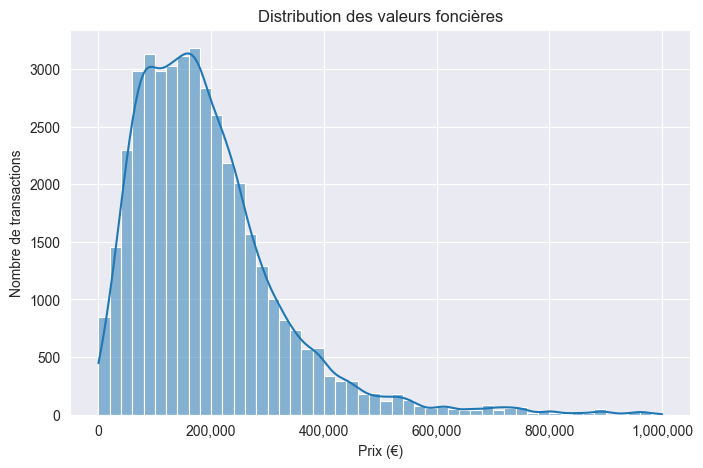

In [187]:
# Distribution of real estate prices
plt.figure(figsize=(8, 5))
sns.histplot(df_data[df_data.valeur_fonciere <= 1e6].valeur_fonciere, bins=50, kde=True)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de transactions")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))
plt.show()

# 4. Visualization of real estate data by property type
## 4.1. Relationship between built area and price by property type


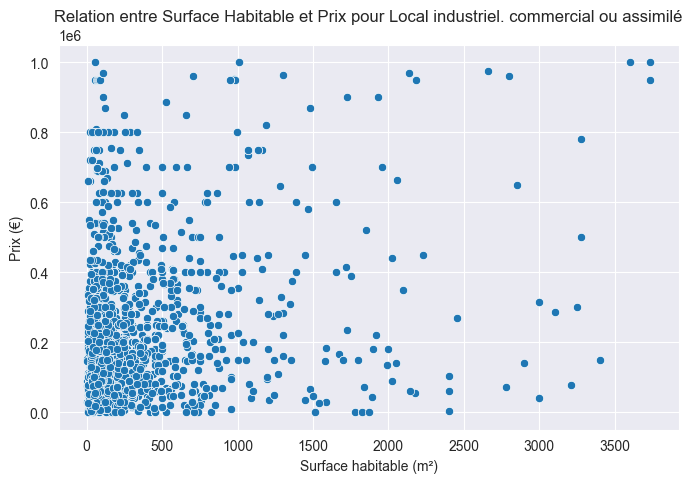

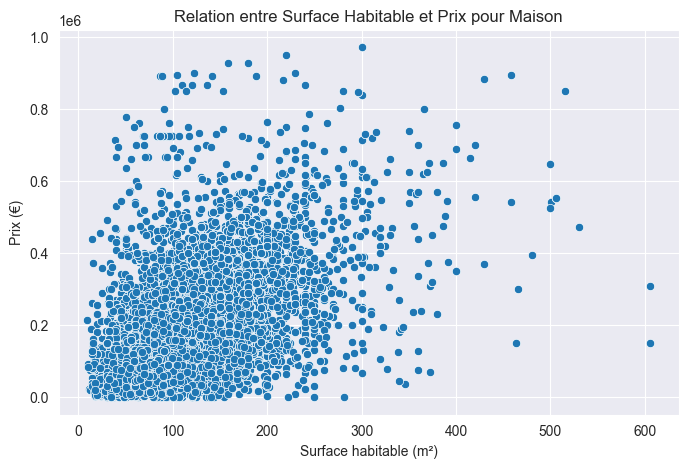

In [188]:
# Get unique property types
unique_types = df_data.columns[df_data.columns.str.startswith("type_local_")]

# Create a separate chart for each property type
for type_col in unique_types:
    type_name = type_col.replace("type_local_", "")  # Extract the property type name
    subset = df_data[(df_data[type_col] == 1) & (df_data.surface_reelle_bati <= 4000) & (df_data.valeur_fonciere <= 1e6)]  # Filtrer les données

    # Check if the subset contains data
    if not subset.empty:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=subset.surface_reelle_bati, y=subset.valeur_fonciere)
        plt.title(f"Relation entre Surface Habitable et Prix pour {type_name}")
        plt.xlabel("Surface habitable (m²)")
        plt.ylabel("Prix (€)")
        plt.show()

## 4.2. Distribution of property types in the dataset

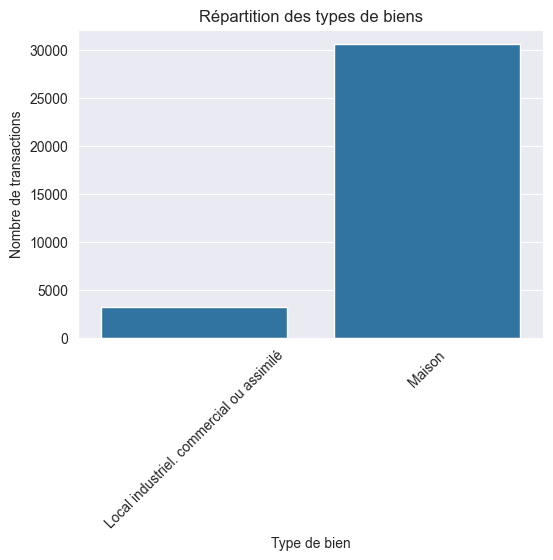

In [189]:
# Distribution of property types
plt.figure(figsize=(6, 4))

# Extract the names of property types
type_local_columns = [col for col in df_data.columns if col.startswith("type_local_")]

# Count the number of occurrences for each property type
type_counts = {col.replace("type_local_", ""): df_data[col].sum() for col in type_local_columns}

# Create a DataFrame for visualization
df_type_counts = pd.DataFrame.from_dict(type_counts, orient="index", columns=["count"]).reset_index()
df_type_counts.rename(columns={"index": "type_local"}, inplace=True)

# Plot the chart
sns.barplot(x="type_local", y="count", data=df_type_counts)
plt.title("Répartition des types de biens")
plt.xticks(rotation=45)
plt.xlabel("Type de bien")
plt.ylabel("Nombre de transactions")
plt.show()


# 5. Data modeling
## 5.1. Feature selection and decision tree model training

In [190]:
# Features selection
features = [
    "surface_reelle_bati", "surface_terrain", "nombre_pieces_principales",
    "code_postal", "prix_m2", "annee_mutation", "mois_mutation"
] + [col for col in df_data.columns if col.startswith("type_local_")]


# Encode only the 'code_postal' column if necessary
data_encoded = pd.get_dummies(df_data[features], columns=["code_postal"], drop_first=True)

X = data_encoded
y = df_data["valeur_fonciere"]

# Split the data into training and test sets (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluation
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Decision Tree - MAE : {mae_tree:.2f} € | R² : {r2_tree:.2f}")

Decision Tree - MAE : 61411.87 € | R² : 0.67


## 5.2. Random forest model training and evaluation

In [191]:
# Initialize and train the Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE : {mae_rf:.2f} € | R² : {r2_rf:.2f}")

Random Forest - MAE : 8133.89 € | R² : 0.97


# 6. Evaluating feature importance for real estate price prediction

In [192]:
importances = rf_model.feature_importances_
feature_names = X.columns
# Convert into DataFrame
df_importances = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Group the values of postal codes and property types
df_importances["Feature"] = df_importances["Feature"].replace({r"code_postal_.*": "code_postal", 
                                                                r"type_local_.*": "type_local"}, regex=True)

# Average importance by grouped category
df_grouped = df_importances.groupby("Feature")["Importance"].sum().reset_index()

# Sort and display the results
df_grouped = df_grouped.sort_values(by="Importance", ascending=False)
print(df_grouped)

                     Feature  Importance
4                    prix_m2    0.470610
5        surface_reelle_bati    0.423806
2              mois_mutation    0.046480
1                code_postal    0.021725
6            surface_terrain    0.020646
7                 type_local    0.007187
0             annee_mutation    0.005983
3  nombre_pieces_principales    0.003563


# 7. Optimizing random forest model performance through hyperparameter tuning
## 7.1 Hyperparameter search with grid search for random forest optimization


In [193]:
# Define the grid of parameters to test
param_grid = {
    'n_estimators': [100,200], 
    'max_depth': [10, 20], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Start the search for the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best parameters :", grid_search.best_params_)

# Recalculate the model with the best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# New evaluation
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Optimized Random Forest - MAE : {mae_best:.2f} € | R² : {r2_best:.2f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest - MAE : 1821.50 € | R² : 0.98


## 7.2 Enhanced random forest model with best hyperparameters

In [194]:
# Enhanced Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, min_samples_split=2, min_samples_leaf=1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE : {mae_rf:.2f} € | R² : {r2_rf:.2f}")

Random Forest - MAE : 1821.50 € | R² : 0.98


# 8. Analysis and visualization of real estate data
## 8.1. Correlation matrix of numerical variables

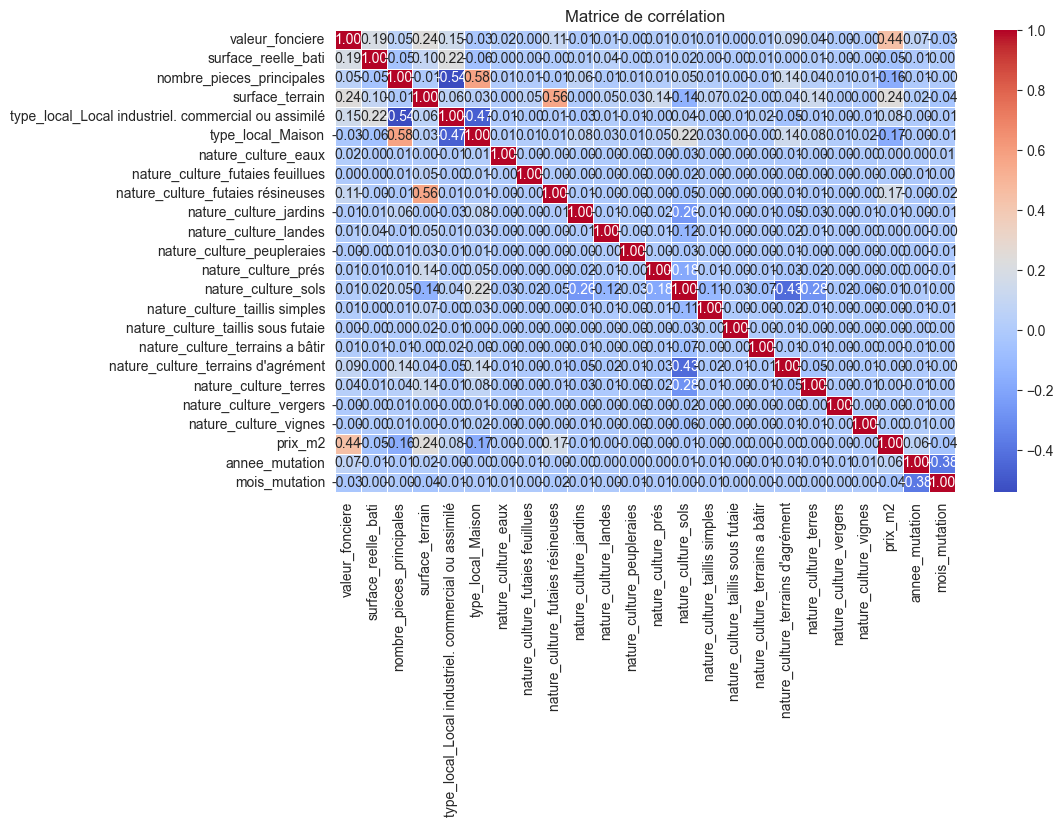

In [195]:
# Correlation matrix
plt.figure(figsize=(10, 6))
corr = df_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

## 8.2. Relationship between built-up area and land value

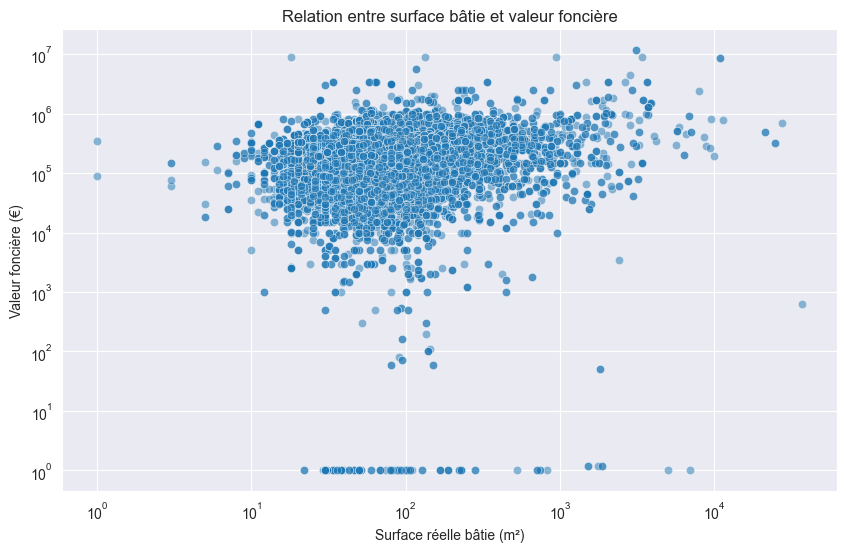

In [196]:
# Relationship between built-up area and land value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_data['surface_reelle_bati'], y=df_data['valeur_fonciere'], alpha=0.5)
plt.xscale('log')  # Échelle log pour mieux visualiser les tendances
plt.yscale('log')
plt.title('Relation entre surface bâtie et valeur foncière')
plt.xlabel('Surface réelle bâtie (m²)')
plt.ylabel('Valeur foncière (€)')
plt.show()

## 8.3. Average property price by postal code

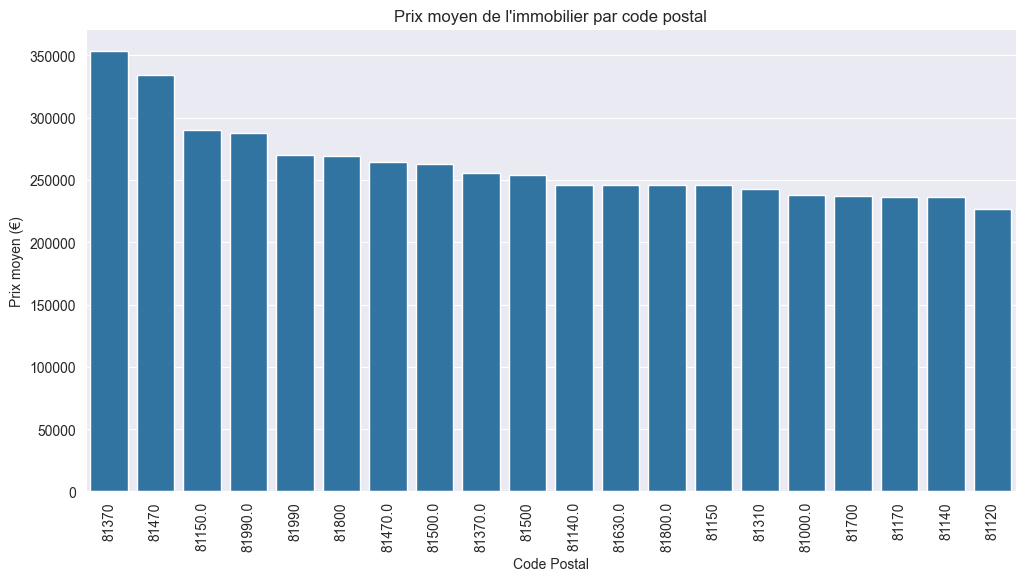

In [197]:
# Average price by postal code
plt.figure(figsize=(12, 6))
code_postal_moy = df_data.groupby('code_postal')['valeur_fonciere'].mean().sort_values(ascending=False)[:20]
sns.barplot(x=code_postal_moy.index, y=code_postal_moy.values)
plt.xticks(rotation=90)
plt.title("Prix moyen de l'immobilier par code postal")
plt.xlabel('Code Postal')
plt.ylabel('Prix moyen (€)')
plt.show()

## 8.4. Yearly average property price trend

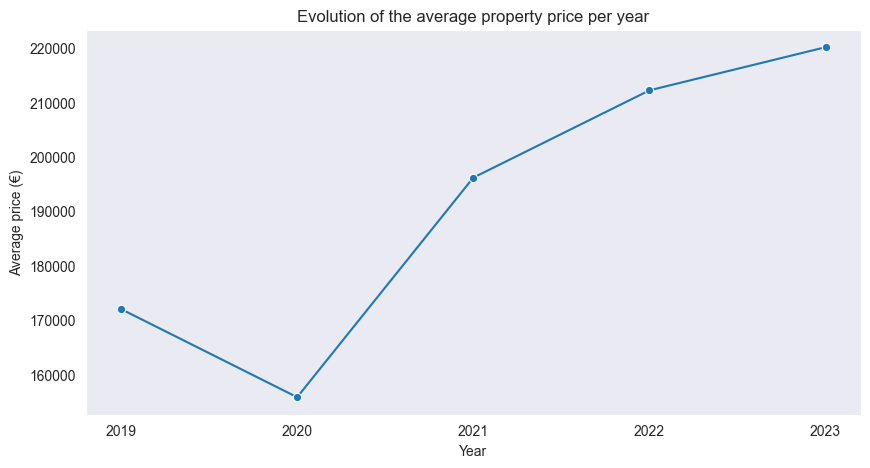

In [198]:
# This code generates a line plot showing the evolution of the average property price
# over the years. It groups the data by year, calculates the mean price for each year,
# and then visualizes the trend using a line plot with markers for each year.
plt.figure(figsize=(10, 5))
df_yearly = df_data.groupby("annee_mutation")["valeur_fonciere"].mean()
sns.lineplot(x=df_yearly.index, y=df_yearly.values, marker="o")
plt.title("Evolution of the average property price per year")
plt.xlabel("Year")

plt.ylabel("Average price (€)")
plt.xticks(df_yearly.index.astype(int))
plt.grid()
plt.show()


## 8.5. Monthly average property price trend (by month and year)

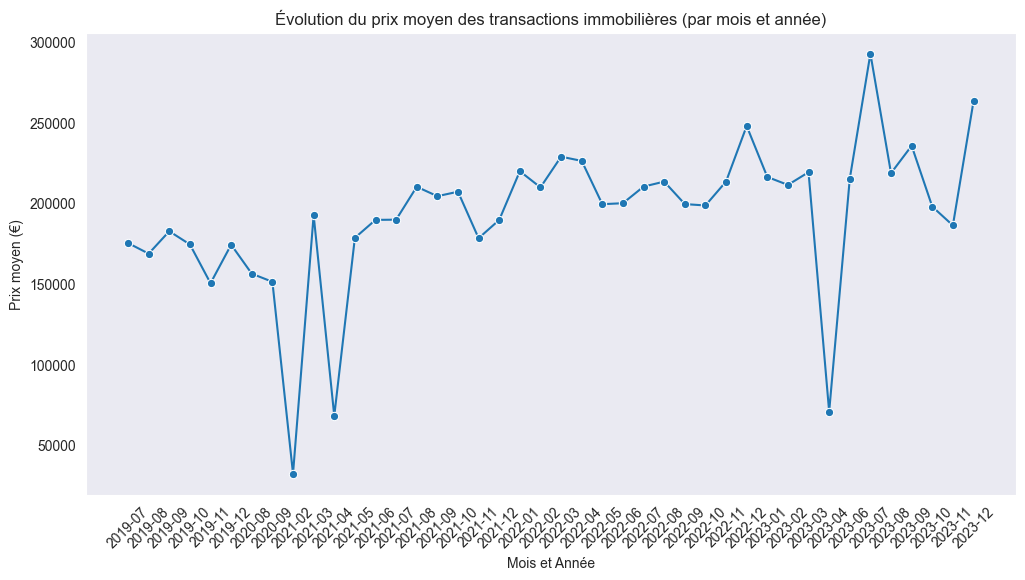

In [199]:
# This code creates a line plot to visualize the average property price evolution
# on a monthly and yearly basis. It groups the data by year-month, calculates
# the mean property price for each period, and then displays the trend with markers
# on the line plot, with properly rotated labels for better readability.
plt.figure(figsize=(12, 6))
sns.lineplot(x="annee_mois", y="valeur_fonciere", data=df_monthly, marker="o")
plt.title("Évolution du prix moyen des transactions immobilières (par mois et année)")
plt.xlabel("Mois et Année")
plt.ylabel("Prix moyen (€)")
plt.xticks(rotation=45)
plt.grid()
plt.show()